In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

# Load Dataset 

In [ ]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full.parquet')
dataset.drop(columns=['lon', 'lat'], inplace=True, errors='ignore')

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print(dataset.isnull().sum())

X = dataset.drop('fire', axis=1)
X_string_columns = X.select_dtypes(include=['object']).columns
X[X_string_columns] = OrdinalEncoder().fit_transform(X[X_string_columns])

Y = dataset['fire']

print(X.head())
print(Y.head())

X_train, X_test, Y_train, Y_test = train_test_split(
    X.to_numpy(), Y.to_numpy(),
    test_size=0.2,      # 20% test
    random_state=42,    # for reproducibility
    shuffle=True        # default True
)

fire                      0
log_precip_s1             0
log_precip_s2             0
log_precip_s3             0
log_precip_s4             0
tmax_s1                   0
tmax_s2                   0
tmax_s3                   0
tmax_s4                   0
amplitude_thermique_s1    0
amplitude_thermique_s2    0
amplitude_thermique_s3    0
amplitude_thermique_s4    0
GRIDCODE                  0
log_area_sqm              0
lcc_code_encoded          0
elevation                 0
COARSE                    0
SAND                      0
SILT                      0
CLAY                      0
TEXTURE_USDA              0
TEXTURE_SOTER             0
BULK                      0
REF_BULK                  0
ORG_CARBON                0
PH_WATER                  0
TOTAL_N                   0
CN_RATIO                  0
CEC_SOIL                  0
CEC_CLAY                  0
CEC_EFF                   0
TEB                       0
BSAT                      0
ALUM_SAT                  0
ESP                 

# SKlearn Model Training

In [ ]:
tree = DecisionTreeClassifier(random_state=42)

tree.fit(X_train, Y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


# Scratch Model Training

# SKlearn Model Testing

Accuracy : 0.9053998180765732
Precision: 0.8163398692810457
Recall   : 0.811038961038961
F1 Score : 0.8136807817589576


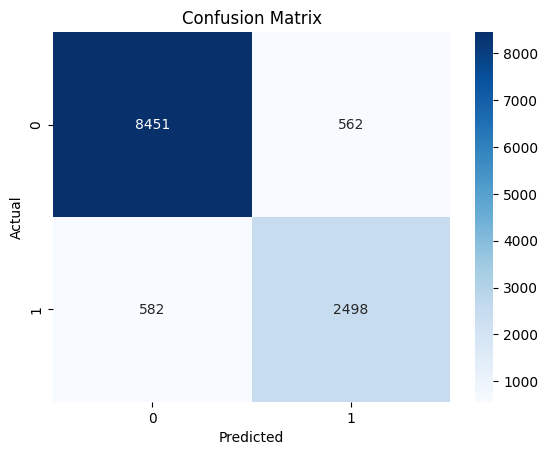

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      9013
           1       0.82      0.81      0.81      3080

    accuracy                           0.91     12093
   macro avg       0.88      0.87      0.88     12093
weighted avg       0.91      0.91      0.91     12093



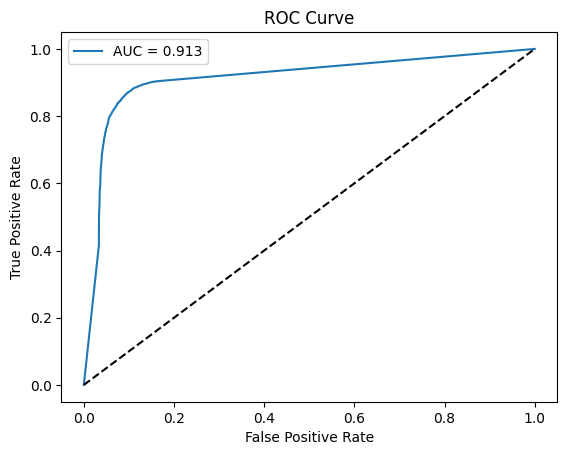

In [ ]:
probs = tree.predict_proba(X_test)
preds = probs.argmax(axis=1)

print("Accuracy :", accuracy_score(Y_test, preds))
print("Precision:", precision_score(Y_test, preds, average='binary'))
print("Recall   :", recall_score(Y_test, preds, average='binary'))
print("F1 Score :", f1_score(Y_test, preds, average='binary'))

cm = confusion_matrix(Y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(Y_test, preds))


fpr, tpr, _ = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Scratch Model Testing

In [10]:
# predictions = knn_scratch.predict(X_test)
# accuracy = (predictions == Y_test).mean() 
# print(f'Scratch KNN Model Accuracy: {accuracy * 100:.2f}%')